## Import libraries

In [1]:
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

import monai
from monai.data import Dataset, ArrayDataset, DataLoader
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, Orientationd, Spacingd, CropForegroundd, ScaleIntensityRangePercentilesd, Resized

import torch
import torch.nn as nn
import torch.nn.functional as F

# reload if update
import importlib
import util
importlib.reload(util)

# Set the random seed
seed = 123
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

## Load data and visualize

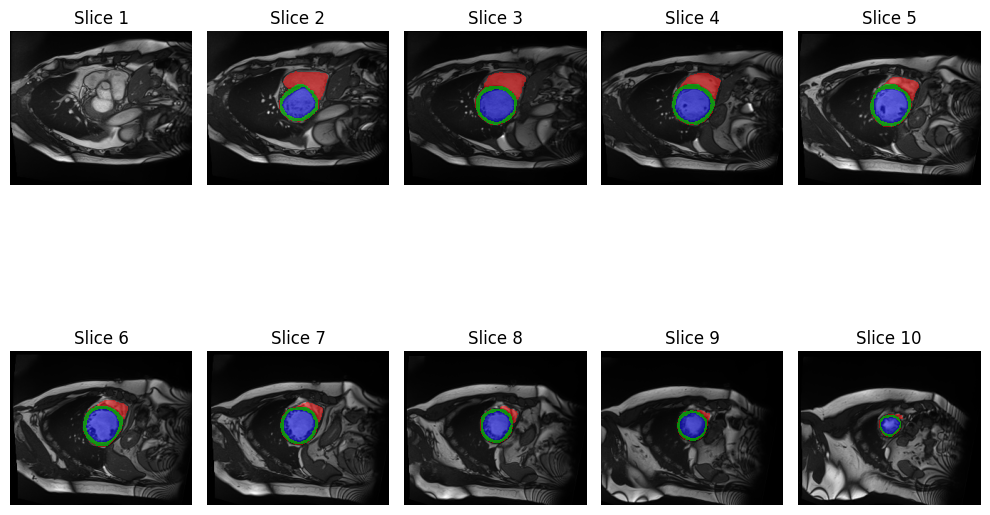

In [4]:
# visualize raw example before preprocessing
file_dict1 = util.load_file_dict(1,'ED')
data_dict1 = util.load_data_dict(1,'ED')
util.visualize_3D(data_dict1)

In [2]:
train_dicts = []
for patient_id in range(1,101):
    train_dicts.append(util.load_file_dict(patient_id,'ED'))
    train_dicts.append(util.load_file_dict(patient_id,'ES'))

test_dicts = []
for patient_id in range(101,151):
    test_dicts.append(util.load_file_dict(patient_id,'ED'))
    test_dicts.append(util.load_file_dict(patient_id,'ES'))

len(train_dicts), len(test_dicts), train_dicts[0]

(200,
 100,
 {'image': './database/training/patient001/patient001_frame01.nii.gz',
  'label': './database/training/patient001/patient001_frame01_gt.nii.gz'})

## Preprocessing

In [4]:
class CropForegroundSquared:
    '''
    crop input using bounding box with flex margin such that output is square
    '''
    def __init__(self, keys, source_key, min_margin):
        self.keys = keys
        self.source_key = source_key
        self.min_margin = min_margin

    def __call__(self, img_dict):
        mask = img_dict[self.source_key] > 0
        idx = torch.argwhere(mask)
        mins,_ = idx.min(dim=0)
        maxs,_ = idx.max(dim=0)
        _, a, b, _ = maxs - mins
        z_s = mins[3]
        z_e = maxs[3]+1
        if a >= b:
            off = (a-b)//2
            x_s = mins[1]-self.min_margin
            x_e = maxs[1]+self.min_margin+1
            y_s = mins[2]-self.min_margin-off
            y_e = maxs[2]+self.min_margin+off+1
        else:
            off = (b-a)//2
            x_s = mins[1]-self.min_margin-off
            x_e = maxs[1]+self.min_margin+off+1
            y_s = mins[2]-self.min_margin
            y_e = maxs[2]+self.min_margin+1
        for k in self.keys:
            img_dict[k] = img_dict[k][:,x_s:x_e,y_s:y_e,z_s:z_e]
        return img_dict


class To2DSlice:
    '''
    permute depth dimension to first channel
    return [image, label] of dimension (D,1,H,W)
    '''
    def __init__(self, keys):
        self.keys = keys

    def __call__(self, img_dict):
        ret = []
        for k in self.keys:
            ret.append(img_dict[k].permute(3,0,1,2))
        return ret

train_transforms = Compose(
    [LoadImaged(keys=["image", "label"]),
     EnsureChannelFirstd(keys=["image", "label"]),
     Orientationd(keys=["image", "label"], axcodes="RAS"),
     Spacingd(
        keys=["image", "label"],
        pixdim=[1.25, 1.25, 10],
        mode=("bilinear", "nearest")),
     CropForegroundSquared(keys=["image", "label"], source_key="label", min_margin=5),
     ScaleIntensityRangePercentilesd(
        keys=["image"],
        lower=5,
        upper=95,
        b_min=0.0,
        b_max=1.0,
        clip=True),
     Resized(
        keys=["image", "label"],
        spatial_size=(128,128,-1),
        mode=("trilinear", "nearest")),
     To2DSlice(keys=["image", "label"])])

test_transforms = Compose(
    [LoadImaged(keys=["image", "label"]),
     EnsureChannelFirstd(keys=["image", "label"]),
     Orientationd(keys=["image", "label"], axcodes="RAS"),
     Spacingd(
        keys=["image", "label"],
        pixdim=[1.25, 1.25, 10],
        mode=("bilinear", "nearest")),
     CropForegroundSquared(keys=["image", "label"], source_key="label", min_margin=5),
     ScaleIntensityRangePercentilesd(
        keys=["image"],
        lower=5,
        upper=95,
        b_min=0.0,
        b_max=1.0,
        clip=True),
     Resized(
        keys=["image", "label"],
        spatial_size=(128,128,-1),
        mode=("trilinear", "nearest")),
     To2DSlice(keys=["image", "label"])])

train_data = []
for train_dict in tqdm(train_dicts, desc='preprocess train set'):
    train_data.append(train_transforms(train_dict))

test_data = []
for test_dict in tqdm(test_dicts, desc='preprocess test set'):
    test_data.append(test_transforms(test_dict))

train_X, train_Y = zip(*train_data)
test_X, test_Y = zip(*test_data)

train_X = torch.concatenate(train_X, dim=0)
train_Y = torch.concatenate(train_Y, dim=0)
test_X = torch.concatenate(test_X, dim=0)
test_Y = torch.concatenate(test_Y, dim=0)

train_X.shape, test_X.shape

preprocess test set: 100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.52it/s]


(torch.Size([1665, 1, 128, 128]), torch.Size([857, 1, 128, 128]))

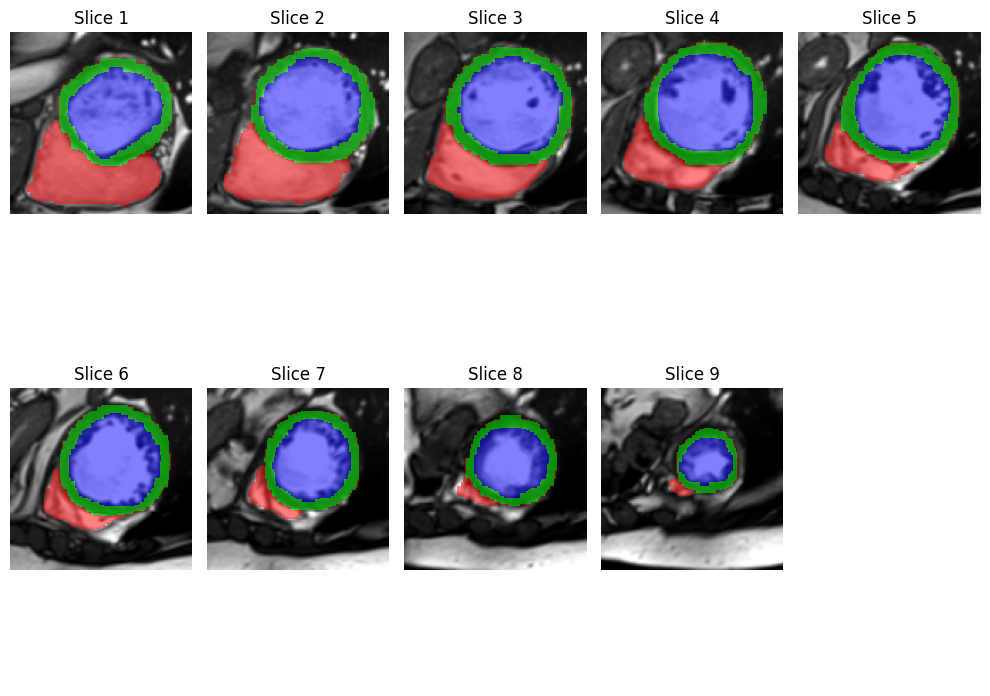

In [13]:
# visualize example after preprocessing
util.visualize_3D({"image": train_X[:9,0].permute(1,2,0),
                   "label": train_Y[:9,0].permute(1,2,0)})

## Prepare dataset and dataloader and data augmentation

In [5]:
from sklearn.model_selection import train_test_split
from monai.transforms import RandFlipd, RandRotated, RandAdjustContrastd, RandZoomd


TRAIN_RATIO = 0.7
BATCH_SIZE = 64
BATCH_SIZE_VAL = 64
PROB = 0.3

# split train and validation
train_X, val_X, train_Y, val_Y = train_test_split(train_X, train_Y, train_size=TRAIN_RATIO)
train_dict = [{"image":train_X[i], "label":train_Y[i]} for i in range(len(train_X))]

# data augmentation
data_aug = Compose([
    RandFlipd(
        keys=["image", "label"],
        spatial_axis=[0],
        prob=PROB),
    RandFlipd(
        keys=["image", "label"],
        spatial_axis=[1],
        prob=PROB),

    RandRotated(
        keys=["image", "label"],
        range_x=0.25*np.pi, # [-45,45]
        prob=PROB),

    RandZoomd(
        keys=["image", "label"],
        min_zoom=0.8, max_zoom=1.2,
        prob=PROB,
    ),
    RandAdjustContrastd( # Randomly changes image intensity by gamma
        # x = ((x - min) / intensity_range) ^ gamma * intensity_range + min
        keys=["image"],
        prob=PROB)])

train_set = Dataset(train_dict, transform=data_aug)
train_set_wo_da = Dataset(train_dict, transform=None) # without data augmentation

val_set = ArrayDataset(img=val_X, seg=val_Y)
test_set = ArrayDataset(img=test_X, seg=test_Y)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
train_loader_wo_da = DataLoader(train_set_wo_da, batch_size=BATCH_SIZE, shuffle=True) # without data augmentation

val_loader = DataLoader(val_set, batch_size=BATCH_SIZE_VAL)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE_VAL)

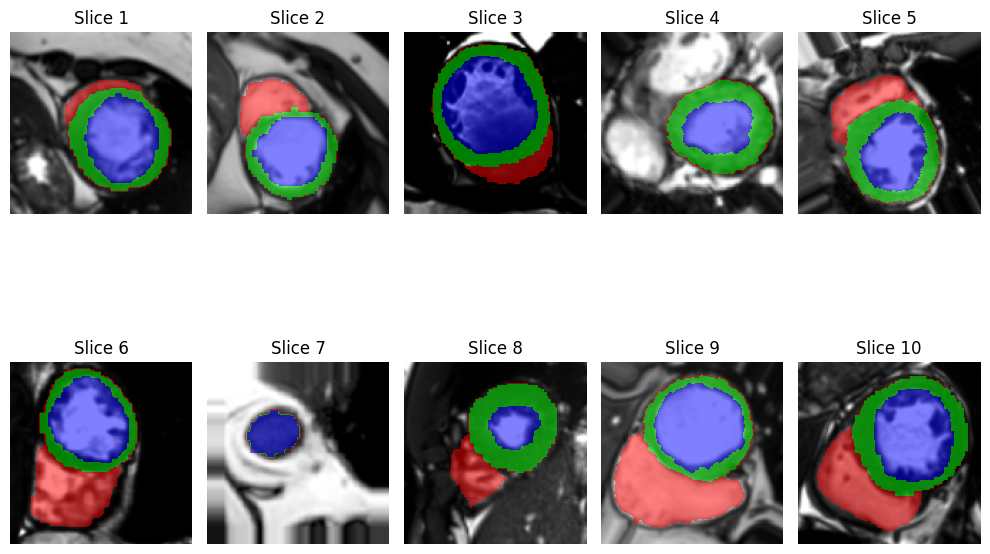

In [21]:
# Visualize the effect of the data augmentation
batch = next(iter(train_loader))
# batch['image'].shape, batch['label'].shape
util.visualize_3D({'image': batch['image'][:10, 0].permute(1,2,0), 'label': batch['label'][:10, 0].permute(1,2,0)})

## Train a U-Net

In [6]:
from unet import UNet

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LR = 1e-2
EPOCH = 150
# SAVE_UNET_PATH = 'saved_models/best_unet_aug.pt'
SAVE_UNET_PATH = 'saved_models/tmp.pt'
if not os.path.exists('saved_models'):
    os.makedirs('saved_models')


In [17]:
def compute_eval_loss(model, val_loader, loss_function):

    epoch_val_loss = 0
    with torch.no_grad():
        for batch_data in val_loader:
            inputs = batch_data[0]
            labels = batch_data[1]

            outputs = model(inputs.to(DEVICE))
            loss = loss_function(outputs, labels.to(DEVICE))

            # print(loss.item())
            epoch_val_loss += loss.item()

    return epoch_val_loss / len(val_loader)


def train(model, train_loader, val_loader, test_loader, save_path):
    # train model
    model.train()

    # Compute both Dice loss and Cross Entropy Loss, and return the weighted sum of these two losses
    loss_function = monai.losses.DiceCELoss(softmax=True, to_onehot_y=True,
                                            lambda_dice=1, lambda_ce=0.1)

    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    training_losses = []
    val_losses = []

    min_val_loss = np.inf
    best_epoch = 0

    for epoch in range(EPOCH):
        epoch_loss = 0

        for batch_data in train_loader:
            inputs = batch_data['image'].to(DEVICE)
            labels = batch_data['label'].to(DEVICE)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()

            optimizer.step()

            epoch_loss += loss.item()

        training_loss = epoch_loss / len(train_loader)
        training_losses.append(training_loss)

        # compute loss on validation set
        val_loss = compute_eval_loss(model, val_loader, loss_function)
        val_losses.append(val_loss)

        print(f'\nepoch {epoch}/{EPOCH} training loss: {training_loss} validation loss: {val_loss}')

        # if minimum validation loss, save model
        if val_loss < min_val_loss:
            torch.save(model.state_dict(), save_path)
            print('New minimum validation loss')
            min_val_loss = val_loss
            best_epoch = epoch
        else:
            print('No improvement on validation loss')


    model.load_state_dict(torch.load(save_path))
    print(f'Best validation error {min_val_loss:.4f} is achieved at epoch {best_epoch}')

    test_loss = compute_eval_loss(model, test_loader, loss_function)
    print(f'Test loss {test_loss:.4f}.')


    return {
        "training_losses": training_losses,
        "val_losses": val_losses,
        "best_epoch": best_epoch,
    }


In [73]:
# define model, loss function and optimizer
model = UNet(n_channels=1, n_classes=4).to(DEVICE)

ret_dict = train(model, train_loader, val_loader, test_loader, 'saved_models/w_da.pt')


epoch 0/150 training loss: 0.6547260409907291 validation loss: 0.4567990265786648
New minimum validation loss

epoch 1/150 training loss: 0.4938311247449172 validation loss: 0.39993834868073463
New minimum validation loss

epoch 2/150 training loss: 0.44806745491529765 validation loss: 0.37522822991013527
New minimum validation loss

epoch 3/150 training loss: 0.4120890090340062 validation loss: 0.3684824965894222
New minimum validation loss

epoch 4/150 training loss: 0.3916013711377194 validation loss: 0.3210366815328598
New minimum validation loss

epoch 5/150 training loss: 0.36361661710237203 validation loss: 0.3005497306585312
New minimum validation loss

epoch 6/150 training loss: 0.34383558599572434 validation loss: 0.2750631086528301
New minimum validation loss

epoch 7/150 training loss: 0.3290441349933022 validation loss: 0.27817881293594837
No improvement on validation loss

epoch 8/150 training loss: 0.30383399991612686 validation loss: 0.24899139814078808
New minimum val

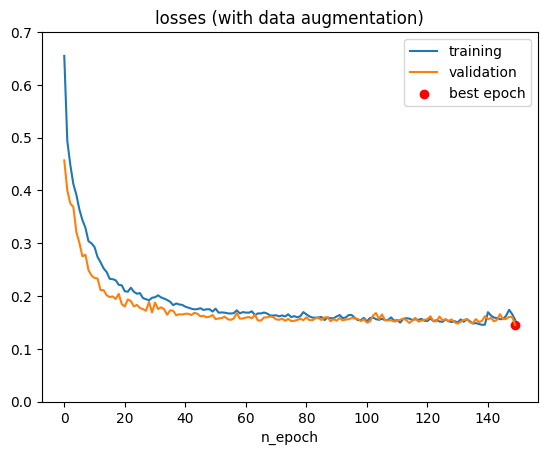

In [74]:
training_losses = ret_dict['training_losses']
val_losses = ret_dict['val_losses']
best_epoch = ret_dict['best_epoch']

plt.plot(training_losses, label='training')
plt.plot(val_losses, label='validation')
plt.scatter([best_epoch], [val_losses[best_epoch]], label='best epoch', color='r')
plt.title('losses (with data augmentation)')
plt.xlabel('n_epoch')
plt.ylim([0,0.7])
# plt.savefig(os.path.join(base_path,'images/train_loss.png'))
plt.legend()
plt.show()

training loss aggregated vs val loss final (best) of epoch

compare with training without data augmentation

In [75]:
model = UNet(n_channels=1, n_classes=4).to(DEVICE)

ret_dict = train(model, train_loader_wo_da, val_loader, test_loader,'saved_models/wo_da.pt')


epoch 0/150 training loss: 0.6265178793355038 validation loss: 0.40055012330412865
New minimum validation loss

epoch 1/150 training loss: 0.3462530201987216 validation loss: 0.3153015822172165
New minimum validation loss

epoch 2/150 training loss: 0.2840791870104639 validation loss: 0.2665345072746277
New minimum validation loss

epoch 3/150 training loss: 0.25990199023171473 validation loss: 0.26786826364696026
No improvement on validation loss

epoch 4/150 training loss: 0.24524267331549995 validation loss: 0.24071419052779675
New minimum validation loss

epoch 5/150 training loss: 0.22917183841529645 validation loss: 0.22057720459997654
New minimum validation loss

epoch 6/150 training loss: 0.20515907751886467 validation loss: 0.20800579525530338
New minimum validation loss

epoch 7/150 training loss: 0.20214491298324183 validation loss: 0.22078274376690388
No improvement on validation loss

epoch 8/150 training loss: 0.20326690297377736 validation loss: 0.2059985101222992
New m

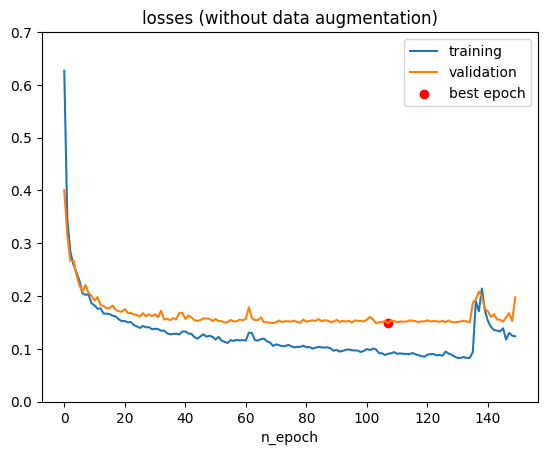

In [76]:
training_losses = ret_dict['training_losses']
val_losses = ret_dict['val_losses']
best_epoch = ret_dict['best_epoch']

plt.plot(training_losses, label='training')
plt.plot(val_losses, label='validation')
plt.scatter([best_epoch], [val_losses[best_epoch]], label='best epoch', color='r')
plt.title('losses (without data augmentation)')
plt.xlabel('n_epoch')
plt.ylim([0,0.7])
# plt.savefig(os.path.join(base_path,'images/train_loss.png'))
plt.legend()
plt.show()

## Performance on test set

load from pretrained weights

In [35]:
from unet import UNet
model_w = UNet(n_channels=1, n_classes=4).to(DEVICE)
model_w.load_state_dict(torch.load('saved_models/w_da.pt', map_location=DEVICE))

model_wo = UNet(n_channels=1, n_classes=4).to(DEVICE)
model_wo.load_state_dict(torch.load('saved_models/wo_da.pt', map_location=DEVICE))

print('Weights loaded')

Weights loaded


In [36]:
# test loss

dice_func = monai.losses.DiceLoss(softmax=True, to_onehot_y=True)

# cross entropy loss
def CE_func(input, target):
    target = torch.squeeze(target, dim=1)
    target = target.long()
    loss = torch.nn.CrossEntropyLoss()(input, target)
    return loss

dice_loss = compute_eval_loss(model_w, test_loader, dice_func)
CE_loss = compute_eval_loss(model_w, test_loader, CE_func)
print(f'w. data augmentation: DICE loss {dice_loss:.4f} CE loss {CE_loss:.4f}')

dice_loss = compute_eval_loss(model_wo, test_loader, dice_func)
CE_loss = compute_eval_loss(model_wo, test_loader, CE_func)
print(f'w.o. data augmentation: DICE loss {dice_loss:.4f} CE loss {CE_loss:.4f}')

w. data augmentation: DICE loss 0.1276 CE loss 0.1510
w.o. data augmentation: DICE loss 0.1320 CE loss 0.2379


In [30]:
postprocess = monai.transforms.Compose([
    monai.transforms.AsDiscrete(argmax=True, to_onehot=4, dim=1),
    monai.transforms.KeepLargestConnectedComponent(applied_labels=(1, 2, 3), independent=False, connectivity=None)
    # TODO: more postprocess
])

def test_performance(model, test_loader):
    model.eval()

    dscs_list = []

    dice_metric = monai.metrics.DiceMetric(include_background=False, # exclude background
                                           # reduction = None,
                                        ignore_empty=True)
    # hd_metric = monai.metrics.HausdorffDistanceMetric()

    for i, test_batch in enumerate(test_loader):

        test_input = test_batch[0]
        with torch.no_grad():
            outputs_test = model(test_input.to(DEVICE))

        outputs_test = postprocess(outputs_test) # (BS, 4, H, W) a 0-1 mask for 4 classes

        y_pred = outputs_test.cpu()
        y_gt = monai.networks.utils.one_hot(test_batch[1],dim=1,num_classes=4)

        dsc = dice_metric(y_pred, y_gt)
        dscs_list.append(dsc)

        # hd = hd_metric(y_pred, y_gt)
        # hds[i] = np.nanmean(hd.numpy(),axis=0)

    dscs = np.concatenate(dscs_list, axis=0)
    print(f'average DICE score on test set: {np.nanmean(dscs):.3f}')
    print(f'average DICE score on test set for class 1: {np.nanmean(dscs[:,0]):.3f}')
    print(f'average DICE score on test set for class 2: {np.nanmean(dscs[:,1]):.3f}')
    print(f'average DICE score on test set for class 3: {np.nanmean(dscs[:,2]):.3f}')
    return dscs

In [37]:
print('w. data augmentation')
dscs_w = test_performance(model_w, test_loader)
print('w.o. data augmentation')
dscs_wo = test_performance(model_wo, test_loader)

w. data augmentation
average DICE score on test set: 0.892
average DICE score on test set for class 1: 0.879
average DICE score on test set for class 2: 0.872
average DICE score on test set for class 3: 0.924
w.o. data augmentation
average DICE score on test set: 0.883
average DICE score on test set for class 1: 0.862
average DICE score on test set for class 2: 0.867
average DICE score on test set for class 3: 0.919


In [40]:
def get_best_worst_batch(dscs, label=0, n=10):
    '''
    Args:
        dscs: array of dice metrics (
        label: get the best/worst performance of class<label>, if 0 return best/worst average
    '''
    if label==0:
        dsc_val = np.nanmean(dscs, axis=1)
    else:
        dsc_val = dscs[:,label-1]
    sorted_val = np.sort(dsc_val)
    sorted_indices = np.argsort(dsc_val)

    if np.isnan(sorted_val).any():
        nan_start_index = (np.isnan(sorted_val)).argmax()
        sorted_indices = sorted_indices[:nan_start_index]

    # smallest (resp. biggest) DICE metrics - worst (resp. best) performance
    worst_indices = sorted_indices[:n]
    best_indices = sorted_indices[-n:][::-1]

    return worst_indices, best_indices

def predict_label(model, test_batch, visualize=False):
    test_input = test_batch[0]

    with torch.no_grad():
        outputs_test = model(test_input.to(DEVICE))

    outputs_test = postprocess(outputs_test) # (BS, 4, H, W) a 0-1 mask for 4 classes

    y_pred = outputs_test.cpu()
    y_gt = monai.networks.utils.one_hot(test_batch[1],dim=1,num_classes=4)


    if visualize:
        label_pred = torch.argmax(outputs_test, dim=1).cpu()
        label_gt = test_batch[1].squeeze()

        print('ground truth')
        util.visualize_3D({"image": test_input[:,0].permute(1,2,0),
                           "label": label_gt[:].permute(1,2,0)})

        print('prediction')
        util.visualize_3D({"image": test_input[:,0].permute(1,2,0),
                           "label": label_pred[:].permute(1,2,0)})


Worst/best average performance

In [41]:
worst_indices_mean, best_indices_mean = get_best_worst_batch(dscs_w, label=0, n=5)
worst_batch = (test_X[worst_indices_mean.copy()], test_Y[worst_indices_mean.copy()])
best_batch = (test_X[best_indices_mean.copy()], test_Y[best_indices_mean.copy()])
worst_indices_mean, best_indices_mean

(array([528, 518, 426, 691, 367]), array([693, 570, 779, 239, 248]))

ground truth


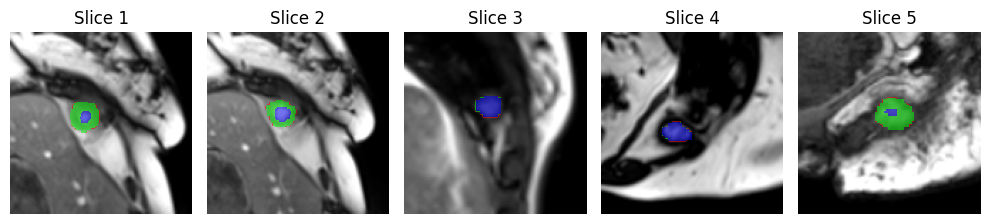

prediction


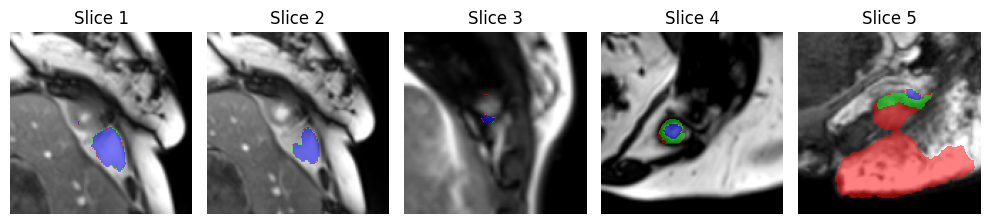

In [43]:
predict_label(model_w, worst_batch, visualize=True)

ground truth


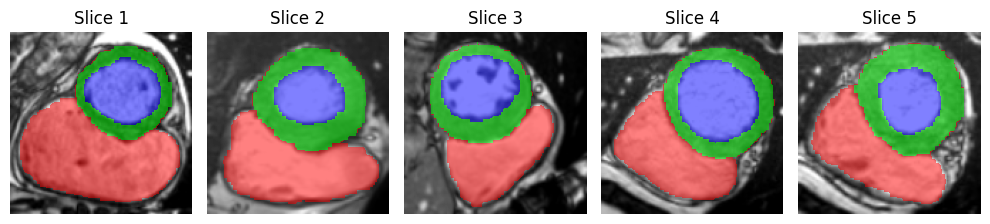

prediction


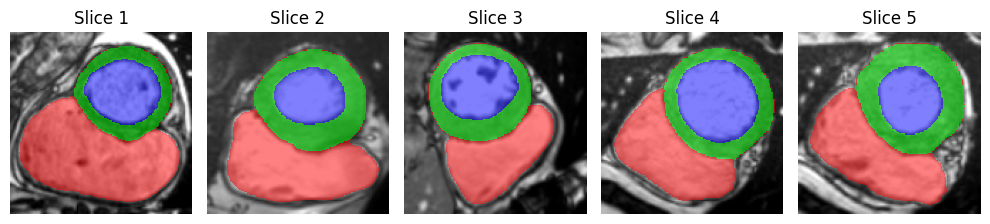

In [44]:
predict_label(model_w, best_batch, visualize=True)
# show corresponding DICE TODO

worst/best performance of class 1 (red)
ground truth


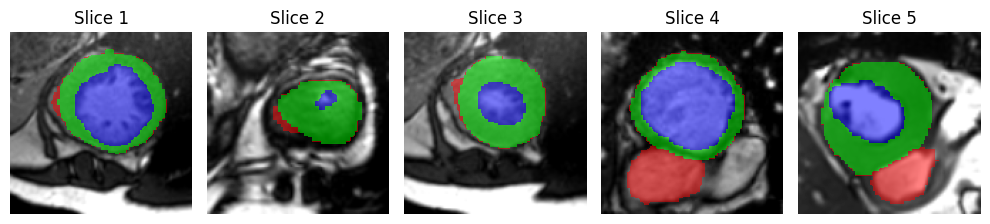

prediction


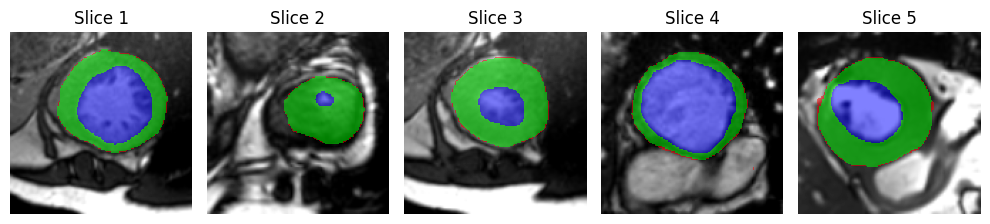

In [46]:
print( "worst/best performance of class 1 (red)" )
worst_indices, best_indices = get_best_worst_batch(dscs_w, label=1, n=5)
worst_batch = (test_X[worst_indices.copy()], test_Y[worst_indices.copy()])
best_batch = (test_X[best_indices.copy()], test_Y[best_indices.copy()])
predict_label(model_w, worst_batch, visualize=True)
# predict_label(model_w, best_batch, visualize=True)

worst/best performance of class 2 (green)
ground truth


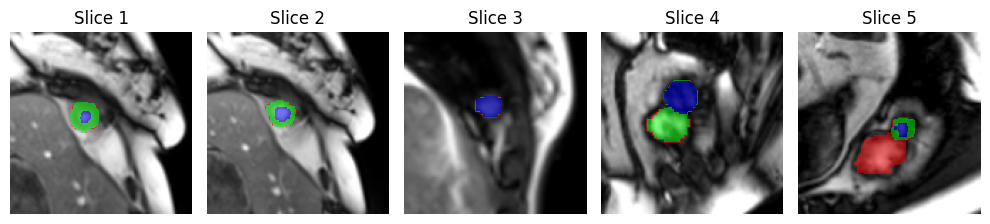

prediction


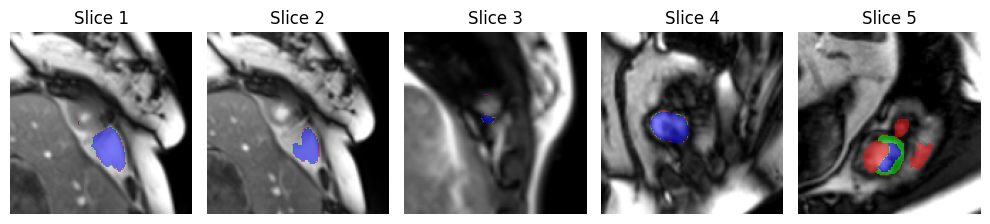

In [47]:
print( "worst/best performance of class 2 (green)" )
worst_indices, best_indices = get_best_worst_batch(dscs_w, label=2, n=5)
worst_batch = (test_X[worst_indices.copy()], test_Y[worst_indices.copy()])
best_batch = (test_X[best_indices.copy()], test_Y[best_indices.copy()])
predict_label(model_w, worst_batch, visualize=True)
# predict_label(model_w, best_batch, visualize=True)

worst/best performance of class 3 (blue)
ground truth


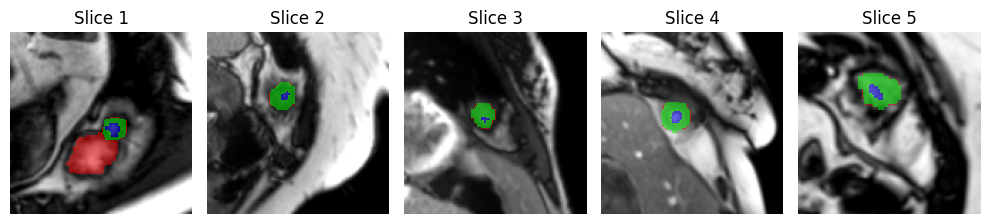

prediction


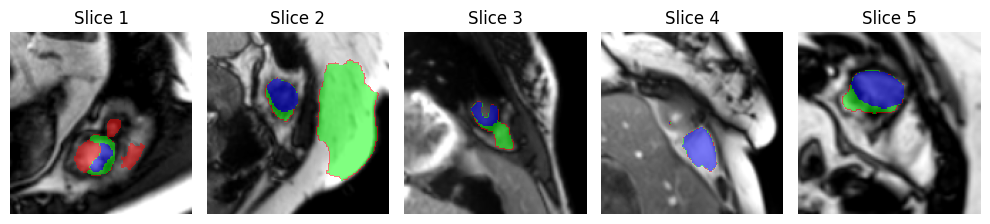

In [48]:
print( "worst/best performance of class 3 (blue)" )
worst_indices, best_indices = get_best_worst_batch(dscs_w, label=3, n=5)
worst_batch = (test_X[worst_indices.copy()], test_Y[worst_indices.copy()])
best_batch = (test_X[best_indices.copy()], test_Y[best_indices.copy()])
predict_label(model_w, worst_batch, visualize=True)
# predict_label(model_w, best_batch, visualize=True)